In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

##### Importing Model and Weights
Imported DeepLabV3+MobileNet, pre-trained model for person segmentation

trained on Pascal VOC dataset [[details]](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_mobilenet_v3_large.html#deeplabv3-mobilenet-v3-large)

In [ ]:
from torchvision.models.segmentation import (
    deeplabv3_mobilenet_v3_large,
    DeepLabV3_MobileNet_V3_Large_Weights,
)

weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=weights)
model.eval()

### Preprocess 
1. PyTorch's transforms demands that functions require input in PIL.Image in RGB Format
2. The DeepLab V3 expects an image of size 513x513
3. a PIL.Image is in the form [H,W,C], while the pytorch models expect [C,H,W]
4. The DeepLabV3 is trained on ImageNet stats with mean = [0.485, 0.456, 0.406] and std  = [0.229, 0.224, 0.225] for RGB layers.
   Therefore, we  need to normalize the input on similar stats. [Link](https://discuss.pytorch.org/t/why-image-datasets-need-normalizing-with-means-and-stds-specified-like-in-transforms-normalize-mean-0-485-0-456-0-406-std-0-229-0-224-0-225/187818)

In [3]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((513, 513)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# Load and preprocess image
def load_image(image_path):
    image = cv2.imread(image_path)[:, :, ::-1]  # cv2 reads image in BGR format. Convert to RGB 
    input_tensor = preprocess(image).unsqueeze(0)  # to make it a batched tensor (4D). helps feed the model. Shape is now (1,3,513,513)
    return image, input_tensor

##### Masking the Person
In DeepLabV3 , the class==15 identifies a person. So, the said class is masked. Assuming every image has person in it. [count the Person class](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#SECTION00031000000000000000)

torch.no_grad() because we take the model and its learned parameters as is.

interpolation is set to INTER_NEAREST for coarse segmentattion

In [5]:
# Segmentation of image and extraction of person mask
def get_person_mask(image_path):
    orig, input_tensor = load_image(image_path)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]  #  batch dimension removed and the current shape is (21, H, W). 21 classes
        seg = torch.argmax(output, dim=0).cpu().numpy() # pixels distributed to classes

    # Class 15 = person
    person_mask = (seg == 15).astype(np.uint8)
    person_mask_resized = cv2.resize(person_mask, (orig.shape[1], orig.shape[0]), interpolation=cv2.INTER_NEAREST)

    return orig, person_mask_resized

##### Working on Background 
assuming lighting is of good quality we can analyze the background by Color uniformity using mean and standard deviation

In [30]:
# Colour uniformity analysis of background
def is_background_uniform(image, person_mask, threshold=36):
    background_pixels = image[person_mask == 0]  #extracting background pixels
    mean = np.mean(background_pixels, axis=0)
    std = np.std(background_pixels, axis=0)
    return np.all(std < threshold), std

###### While executing the function below, set visuals== False if you would like to hide original and person mask images. Else its True by default.

In [7]:
# model to output
def run_for_output(image_path, visuals=False):
    image, mask = get_person_mask(image_path)
    is_uniform, std = is_background_uniform(image, mask)

    # Visualizing results
    if visuals==True:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.imshow(image); plt.title("Original")
        plt.subplot(1, 2, 2); plt.imshow(mask, cmap='gray'); plt.title("Person Mask")
        plt.show()
    else:
        pass

    if is_uniform:
        return 0
    else:
        return 1

##### The below two cells are implementing same function but different form of output. They are only to demosntrate segmentation and std(s) calculated. Please input the image_path to obtain similar outputs.

In [20]:
def run_for_output_dummy(image_path, visuals=False):
    image, mask = get_person_mask(image_path)
    is_uniform, std = is_background_uniform(image, mask)

    # Visualizing results
    if visuals==True:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.imshow(image); plt.title("Original")
        plt.subplot(1, 2, 2); plt.imshow(mask, cmap='gray'); plt.title("Person Mask")
        plt.show()
    else:
        pass

    if is_uniform:
        print(f' Standard_Deviations= {std} Yes! background is uniform')
    else:
        print(f' Standard_Deviations= {std} No! background is not uniform')

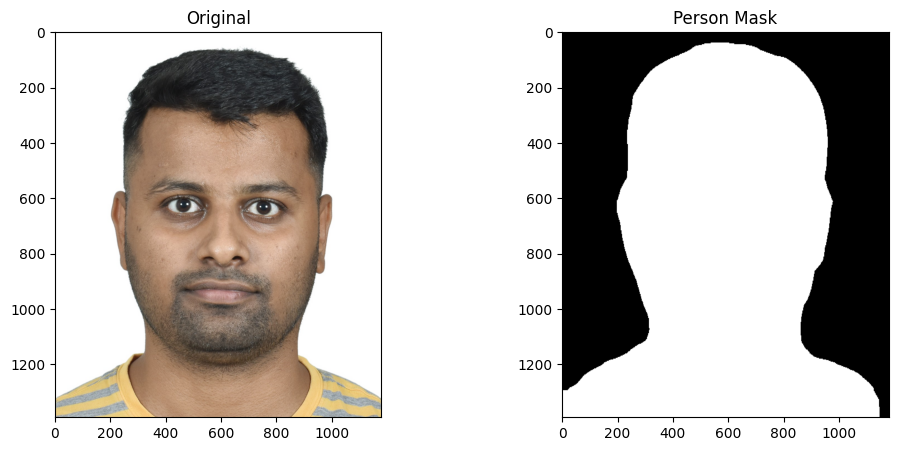

 Standard_Deviations= [30.69205428 32.80575706 35.14555387] Yes! background is uniform


In [21]:
image_path=r"C:\Users\varad\OneDrive\Desktop\SHreeVaradaPhoto.JPG" 
run_for_output_dummy(image_path,visuals=True)

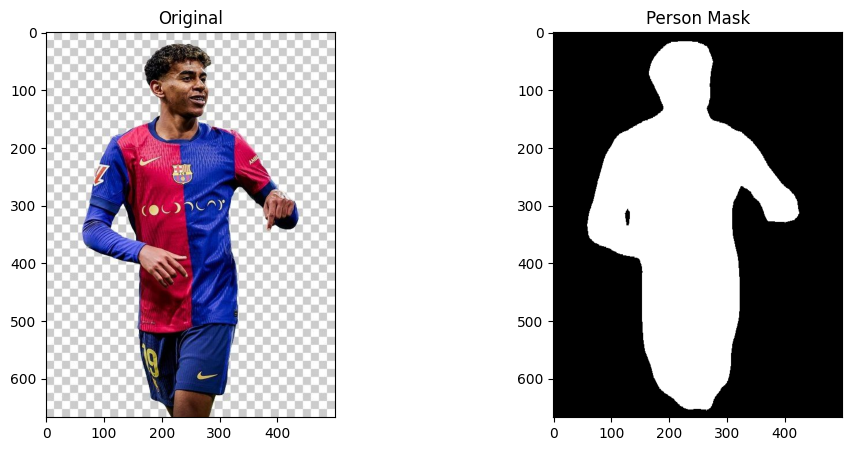

 Standard_Deviations= [41.53325985 41.36448029 36.76356115] No! background is not uniform


In [22]:
image_path=r"C:\Users\varad\OneDrive\Desktop\lamine.jpg"
run_for_output_dummy(image_path,visuals=True)

##### Metrics

Choosing all the images from kaggle data sets and copying their paths into a csv file and manually entering the labels on 'lebel' column. Inputting every image's path into the function and writing the returned values into the same csv file in 'preds' column. The following metrics are determined using that as a dataframe. See the output of df.head(). 

#### 0s are uniform and 1s are non-uniform background

In [9]:
import pandas as pd
df = pd.read_csv(r"C:\Users\varad\OneDrive\Desktop\data\data.csv")  
df['preds'] = df['image_path'].apply(run_for_output)
df.to_csv(r"C:\Users\varad\OneDrive\Desktop\data\data.csv", index=False)

In [11]:
df

,image_path,label,preds
0,C:\Users\varad\Downloads\archive\Image_Train\A...,1,1
1,C:\Users\varad\Downloads\archive\Image_Train\A...,1,1
2,C:\Users\varad\Downloads\archive\Image_Train\A...,1,1
3,C:\Users\varad\Downloads\archive\Image_Train\A...,1,1
4,C:\Users\varad\Downloads\archive\Image_Train\A...,1,1
...,...,...,...
295,C:\Users\varad\Downloads\archive\Image_Train\v...,1,1
296,C:\Users\varad\Downloads\archive\Image_Train\v...,1,1
297,C:\Users\varad\Downloads\archive\Image_Train\v...,1,1
298,C:\Users\varad\Downloads\archive\Image_Train\v...,1,1


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [28]:
y_true = df['label']
y_pred = df['preds']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.9766666666666667
Precision: 0.9930313588850174
Recall: 0.9827586206896551
F1-score: 0.9878682842287695

Confusion Matrix:
 [[  8   2]
 [  5 285]]


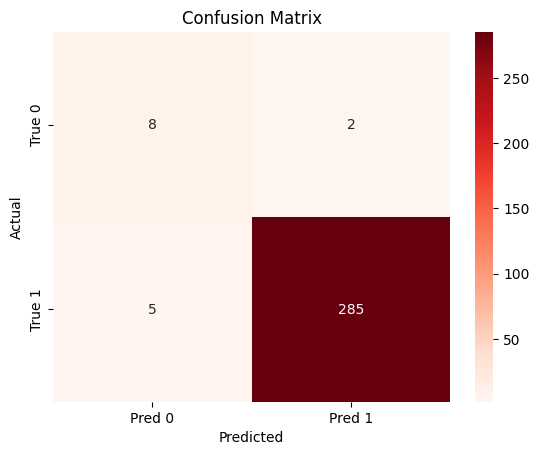

In [29]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()